Enter initial radial distance (AU): 1
Enter initial tangential velocity (AU/yr): 5.654
Enter numer of iterations: 1000
Enter time step (yr): 0.001
 Choose numerical method: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive Runge-Kutta  3


 77%|███████▋  | 771/1000 [00:00<00:00, 10161.67it/s]


period: 0.77 semimajoraxis: 0.84 ecc:  0.19 peri:  0.68
theory period: 0.770
percent difference of period:  0.12%
kinetic mean: 23.49
negative potential mean: 23.49
theory eccentricity:  0.13


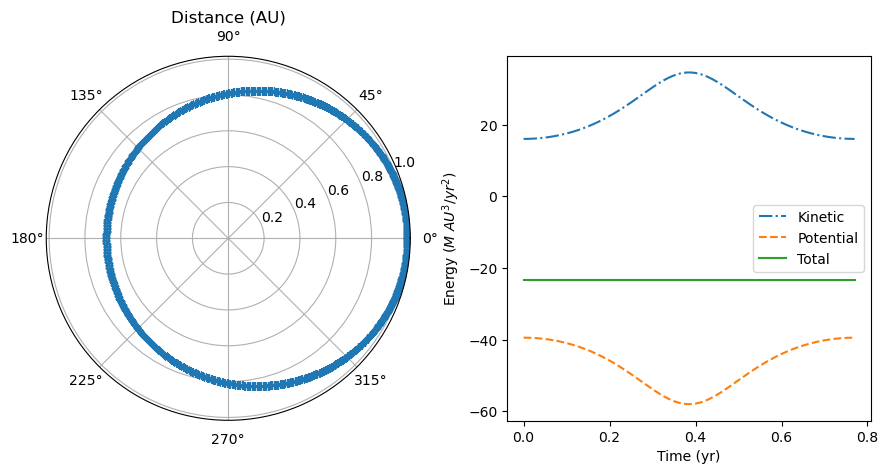

In [27]:
# orbit - Program to compute the orbit of a comet.

# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nm4p.rk4 import rk4
from nm4p.rka import rka


# Define gravrk function used by the Runge-Kutta routines
def gravrk(s, t, GM):
    """
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), v(0), v(1)]
    :param t: Time (not used here, included to match derivsRK input)
    :param GM: Parameter G*M - gravitational constant * solar mass Units [AU^3/yr^2]
    :return: deriv: Derivatives [dr(0/dt), dr(1)/dt, dv(0)/dt, dv(1)/dt]
    """

    # Compute acceleration
    r = s[:2]  # Unravel the vector s into position and velocity
    v = s[2:]
    accel = -GM * r / np.linalg.norm(r)**3  # Gravitational acceleration

    # Return derivatives
    deriv = np.array([v[0], v[1], accel[0], accel[1]])

    return deriv


# Set initial position and velocity of the comet.
r0 = eval(input('Enter initial radial distance (AU): '))
v0 = eval(input('Enter initial tangential velocity (AU/yr): '))
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

# Set physical parameters
GM = 4 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2]
mass = 1.0  # Mass of comet (reference mass)
adaptErr = 1.0E-3  # Error parameter used by adaptive Runge-Kutta
time = 0.0

# Loop over the desired number of steps using the specified numerical method.
nStep = eval(input('Enter numer of iterations: '))
tau = eval(input('Enter time step (yr): '))
NumericalMethod = eval(input(' Choose numerical method: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive Runge-Kutta  '))

rplot = np.empty(nStep)
thplot = np.empty(nStep)
tplot = np.empty(nStep)
kinetic = np.empty(nStep)
potential = np.empty(nStep)
angular = np.empty(nStep)

laststep = nStep
reachhalf = False
peri = r0

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = 0.5*mass*np.linalg.norm(v)**2  # Record kinetic and potential energy
    potential[iStep] = - GM*mass/np.linalg.norm(r)
    angular[iStep] = mass*np.linalg.norm(r)*np.linalg.norm(v)
    
    #indicate the sign of a number 
    if iStep > 4:
        if np.sign(thplot[iStep]) != np.sign(thplot[iStep-1]):
            if reachhalf: 
                laststep = iStep
                break
            else: 
                reachhalf = True
                peri = (rplot[iStep] + rplot[iStep - 1])/2 
        

    # Calculate new position and velocity using the desired method
    if NumericalMethod == 1:
        accel = -GM*r/np.linalg.norm(r)**3
        r += tau*v  # Euler Step
        v += tau*accel
        time += tau
    elif NumericalMethod == 2:
        accel = -GM * r / np.linalg.norm(r) ** 3
        v += tau * accel
        r += tau * v  # Euler-Cromer Step
        time += tau
    elif NumericalMethod == 3:
        state = rk4(state, time, tau, gravrk, GM)
        r = state[:2]  # 4th Order Runge-Kutta
        v = state[2:]
        time += tau
    elif NumericalMethod == 4:
        state, time, tau = rka(state, time, tau, adaptErr, gravrk, GM)
        r = state[:2]  # 4th Order Runge-Kutta
        v = state[2:]
    else:
        raise ValueError('Invalid NumericalMethod input. Choose: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive Runge-Kutta  ')



#commputing period, eccentricity, and semimajoraxis
period = laststep*tau
semimajoraxis = (r0 + peri)/2 
ecc = (r0/semimajoraxis) - 1

print(f'period: {period:.2f}', f'semimajoraxis: {semimajoraxis:.2f}', f'ecc: {ecc: .2f}', f'peri: {peri: .2f}')

#commputing theory period and percent difference between the period
theoryperiod = np.sqrt((4*np.pi**2)*semimajoraxis**3/GM)
print(f'theory period: {theoryperiod:.3f}')

percentperiod = ((period - theoryperiod)/period)*100
print(f'percent difference of period: {percentperiod: .2f}%')
    
    
# Graph the trajectory  and energy of the comet over time.
totalE = kinetic + potential  # total energy

#Confiriming mean kinetic energy is negative mean potential/2 
kinavg = np.mean(kinetic[:laststep])
potentialavg = np.mean(potential[:laststep])
potmean = -(potentialavg)/2

print(f'kinetic mean: {kinavg:.2f}')
print(f'negative potential mean: {potmean:.2f}')

#average Angular Momentum and average total energy 
angavg = np.mean(angular[:laststep])
engavg = np.mean(totalE[:laststep])

#Theory Eccentricity
theoryecc = np.sqrt(1 + (2*engavg*(angavg**2))/((GM**2)*mass**3))
print(f'theory eccentricity: {theoryecc: .2f}')

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot[:laststep], rplot[:laststep], '+',)
ax.set_title('Distance (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot[:laststep], kinetic[:laststep], ls='-.', label='Kinetic')
ax2.plot(tplot[:laststep], potential[:laststep], ls='--', label='Potential')
ax2.plot(tplot[:laststep], totalE[:laststep], ls='-', label='Total')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($M~AU^3/yr^2$)')
ax2.legend()

plt.show()